<h1 style="color: #FFD700; font-weight: bold;">CLASIFICACIÓN DE LONGEVIDAD EN JUGADORES DE LA NBA: PREDICCIÓN DE CARRERAS DURADERAS SEGÚN EL 'ROOKIE YEAR'</h1>

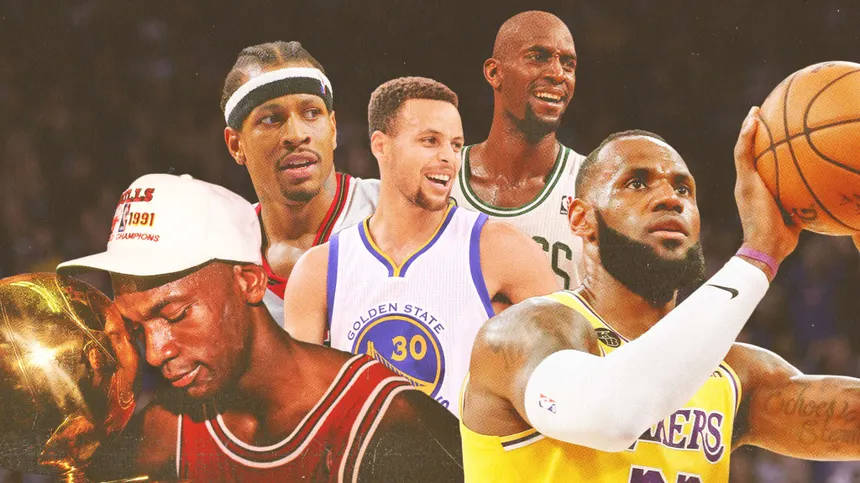


### **Variables dentro del dataset all_seasons.csv**

#### **Identificación y contexto**

* player_name: nombre del jugador.
* team_abbreviation: abreviatura del equipo.
* season: temporada NBA del registro.

#### **Perfil del jugador**

* age: edad del jugador en esa temporada.
* country: país de origen.
* player_height: altura en centímetros.
* player_weight: peso en kilogramos.
* college: universidad de procedencia (si aplica).

#### **Draft y participación**

* draft_year: año de selección en el draft (o “Undrafted”).
* draft_round: ronda del draft (o “Undrafted”).
* draft_number: número global de selección.
* gp: partidos jugados en la temporada.

#### **Rendimiento**

* pts: puntos.
* reb: rebotes.
* ast: asistencias.
* net_rating: impacto neto del jugador por 100 posesiones.
* usg_pct: porcentaje de uso ofensivo.
* ts_pct: eficiencia de tiro (true shooting).
* ast_pct: porcentaje de asistencias generadas.
* oreb_pct: porcentaje de rebotes ofensivos.
* dreb_pct: porcentaje de rebotes defensivos.

## **1. Carga de librerías y dataset**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import f_oneway

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

In [41]:
df = pd.read_csv('./data/all_seasons.csv', sep= ',')
df.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


## **2. Procesado Inicial**

In [42]:
df.shape

(12844, 22)

In [43]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         12844 non-null  int64  
 1   player_name        12844 non-null  str    
 2   team_abbreviation  12844 non-null  str    
 3   age                12844 non-null  float64
 4   player_height      12844 non-null  float64
 5   player_weight      12844 non-null  float64
 6   college            10990 non-null  str    
 7   country            12844 non-null  str    
 8   draft_year         12844 non-null  str    
 9   draft_round        12844 non-null  str    
 10  draft_number       12844 non-null  str    
 11  gp                 12844 non-null  int64  
 12  pts                12844 non-null  float64
 13  reb                12844 non-null  float64
 14  ast                12844 non-null  float64
 15  net_rating         12844 non-null  float64
 16  oreb_pct           12844 non-null

### **2.1 Limpieza de datos**

In [44]:
df['draft_number'] = df['draft_number'].replace('Undrafted', '0')
df['draft_round'] = df['draft_round'].replace('Undrafted', '0')
df['draft_year'] = df['draft_year'].replace('Undrafted', '0')

In [45]:
df[['draft_year',
    'draft_round',
    'draft_number']] = df[['draft_year',
                           'draft_round',
                           'draft_number'
                           ]].astype('Int64')

In [46]:
resultados = {}

for col in df.columns:
    resultados[col] = df[col].apply(
        lambda x: isinstance(x, str) and x.strip() == ''
    ).sum()

faltantes = pd.DataFrame({
    'nulos': df.isna().sum(),
    'vacios': pd.Series(resultados)
})

faltantes.query('nulos != 0 and vacios != 0')

,nulos,vacios
college,1854,5


In [47]:
df['college'] = df['college'].apply(lambda x: 
                                    'Unknown' if pd.isna(x) else x)
df = df[df['college'] != '']

In [48]:
df.describe()

,Unnamed: 0,age,player_height,player_weight,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
count,12844.000000,12844.000000,12844.000000,12844.000000,12844.0,12844.0,12844.0,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000
mean,6421.500000,27.045313,200.555097,100.263279,1636.115151,1.059172,17.774914,51.154158,8.212582,3.558486,1.824681,-2.226339,0.054073,0.140646,0.184641,0.513138,0.131595
std,3707.887763,4.339211,9.111090,12.426628,775.92839,0.683223,16.803276,25.084904,6.016573,2.477885,1.800840,12.665124,0.043335,0.062513,0.053545,0.101724,0.094172
min,0.000000,18.000000,160.020000,60.327736,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,-250.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3210.750000,24.000000,193.040000,90.718400,1991.0,1.0,3.0,31.000000,3.600000,1.800000,0.600000,-6.400000,0.021000,0.096000,0.149000,0.482000,0.066000
50%,6421.500000,26.000000,200.660000,99.790240,2001.0,1.0,14.0,57.000000,6.700000,3.000000,1.200000,-1.300000,0.040000,0.130500,0.181000,0.525000,0.103000
75%,9632.250000,30.000000,208.280000,108.862080,2009.0,1.0,29.0,73.000000,11.500000,4.700000,2.400000,3.200000,0.083000,0.179000,0.217000,0.563000,0.179000
max,12843.000000,44.000000,231.140000,163.293120,2022.0,8.0,165.0,85.000000,36.100000,16.300000,11.700000,300.000000,1.000000,1.000000,1.000000,1.500000,1.000000


### **2.2 Identificación de Clases**

Dado que el objetivo del trabajo es abordar un problema de clasificación, resulta fundamental identificar y definir adecuadamente las clases que se desean predecir a partir del dataset escogido. Luego de revisarlo, este no cuenta de forma explícita con una variable objetivo catégorica, por lo que debemos analizar las variables disponibles y evaluar la posibilidad de clasificación que se pueda plantear.

In [49]:
df.groupby('player_name')['season'].count().sort_values(ascending=False)

player_name
Vince Carter     22
Dirk Nowitzki    21
Udonis Haslem    20
Kobe Bryant      20
LeBron James     20
                 ..
Dino Radja        1
Yves Pons         1
Aaron Miles       1
Aaron Jackson     1
Aaron Henry       1
Name: season, Length: 2551, dtype: int64

En base a la media de temporadas en las que aparece el jugador, crearemos una nueva variable 'longevity' para clasificarlo como un jugador duradero o no. Usaremos a esta para crear una variable binaria y hacer la interpretabilidad para el modelo más sencilla. La media es ~5, si la suma de sus temporadas es <= 5 entonces, será 0, sino será 1.

In [50]:
df['longevity'] = df['player_name'].map(
    df.groupby('player_name')['season'].count()
)

In [51]:
df['career_5plus'] = df['longevity'].apply(lambda x: 1 if x > 5 else 0)
df['career_5plus'].value_counts()

career_5plus
1    8929
0    3915
Name: count, dtype: int64

**Clasificación binaria**

Creé la variable binaria career_5plus que hace referencia a la longevidad de un jugador dentro de la liga. Dado que el dataset cuenta con observaciones por jugador y temporada, utilizamos esta estructura a nuestro favor para calcular cuántas apariciones distintas tiene dicho jugador. El valor que adopta esta variable (0 o 1) está definido como explicamos anteriormente.

Ahora que ya tenemos nuestra variable objetivo definida, debemos reducir el dataset para evitar tener múltiples observaciones de un mismo jugador con un solo valor de 'career_5plus'. Considero que lo más lógico sería quedarnos con el rookie year, así podemos realizar en análisis según como este empezó.

**Clasificación multiclase**

En cuanto a la clasificación multiclase, el dataset no presenta de forma directa una variable categórica natural que permita definir clases múltiples claras y estables. Variables como el país de origen (country) o la universidad (college) contienen un elevado número de categorías y una distribución muy desigual, lo que dificulta su uso como variable objetivo para un problema de clasificación multiclase significativo.

No obstante, es posible plantear alternativas multiclase derivadas, como por ejemplo:

Dividir la longevidad de la carrera en varios niveles (corta, media y larga) a partir de cuantiles.

Definir clases basadas en niveles de rendimiento inicial.

In [52]:
df.sort_values(by=['player_name','season'])[['player_name','season']]
df_player = df.drop_duplicates(subset='player_name', keep='first')
df_player.shape

(2551, 24)

Reducimos a nivel 1 jugador = 1 observación

### **2.3 Análisis de Variables**

#### **Análisis por Longevidad**

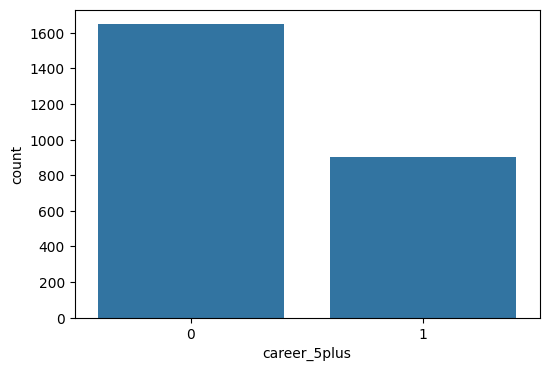

In [250]:
plt.figure(figsize=(6,4))

sns.countplot(df_player, x= 'career_5plus')
plt.show()

In [54]:
columns_to_drop = ['Unnamed: 0', 
                   'player_name', 
                   'team_abbreviation',
                   'season',
                   'college',
                   'country',
                   'longevity'
                   ]

df_player_1 = df_player[df_player['career_5plus'] == 1]
df_player_1.drop(columns=columns_to_drop, inplace=True)

df_player_0 = df_player[df_player['career_5plus'] == 0] 
df_player_0.drop(columns=columns_to_drop, inplace=True)

In [55]:
n = len(df_player_1.columns)
n_columns = 4

import math
n_rows = math.ceil(n/n_columns)

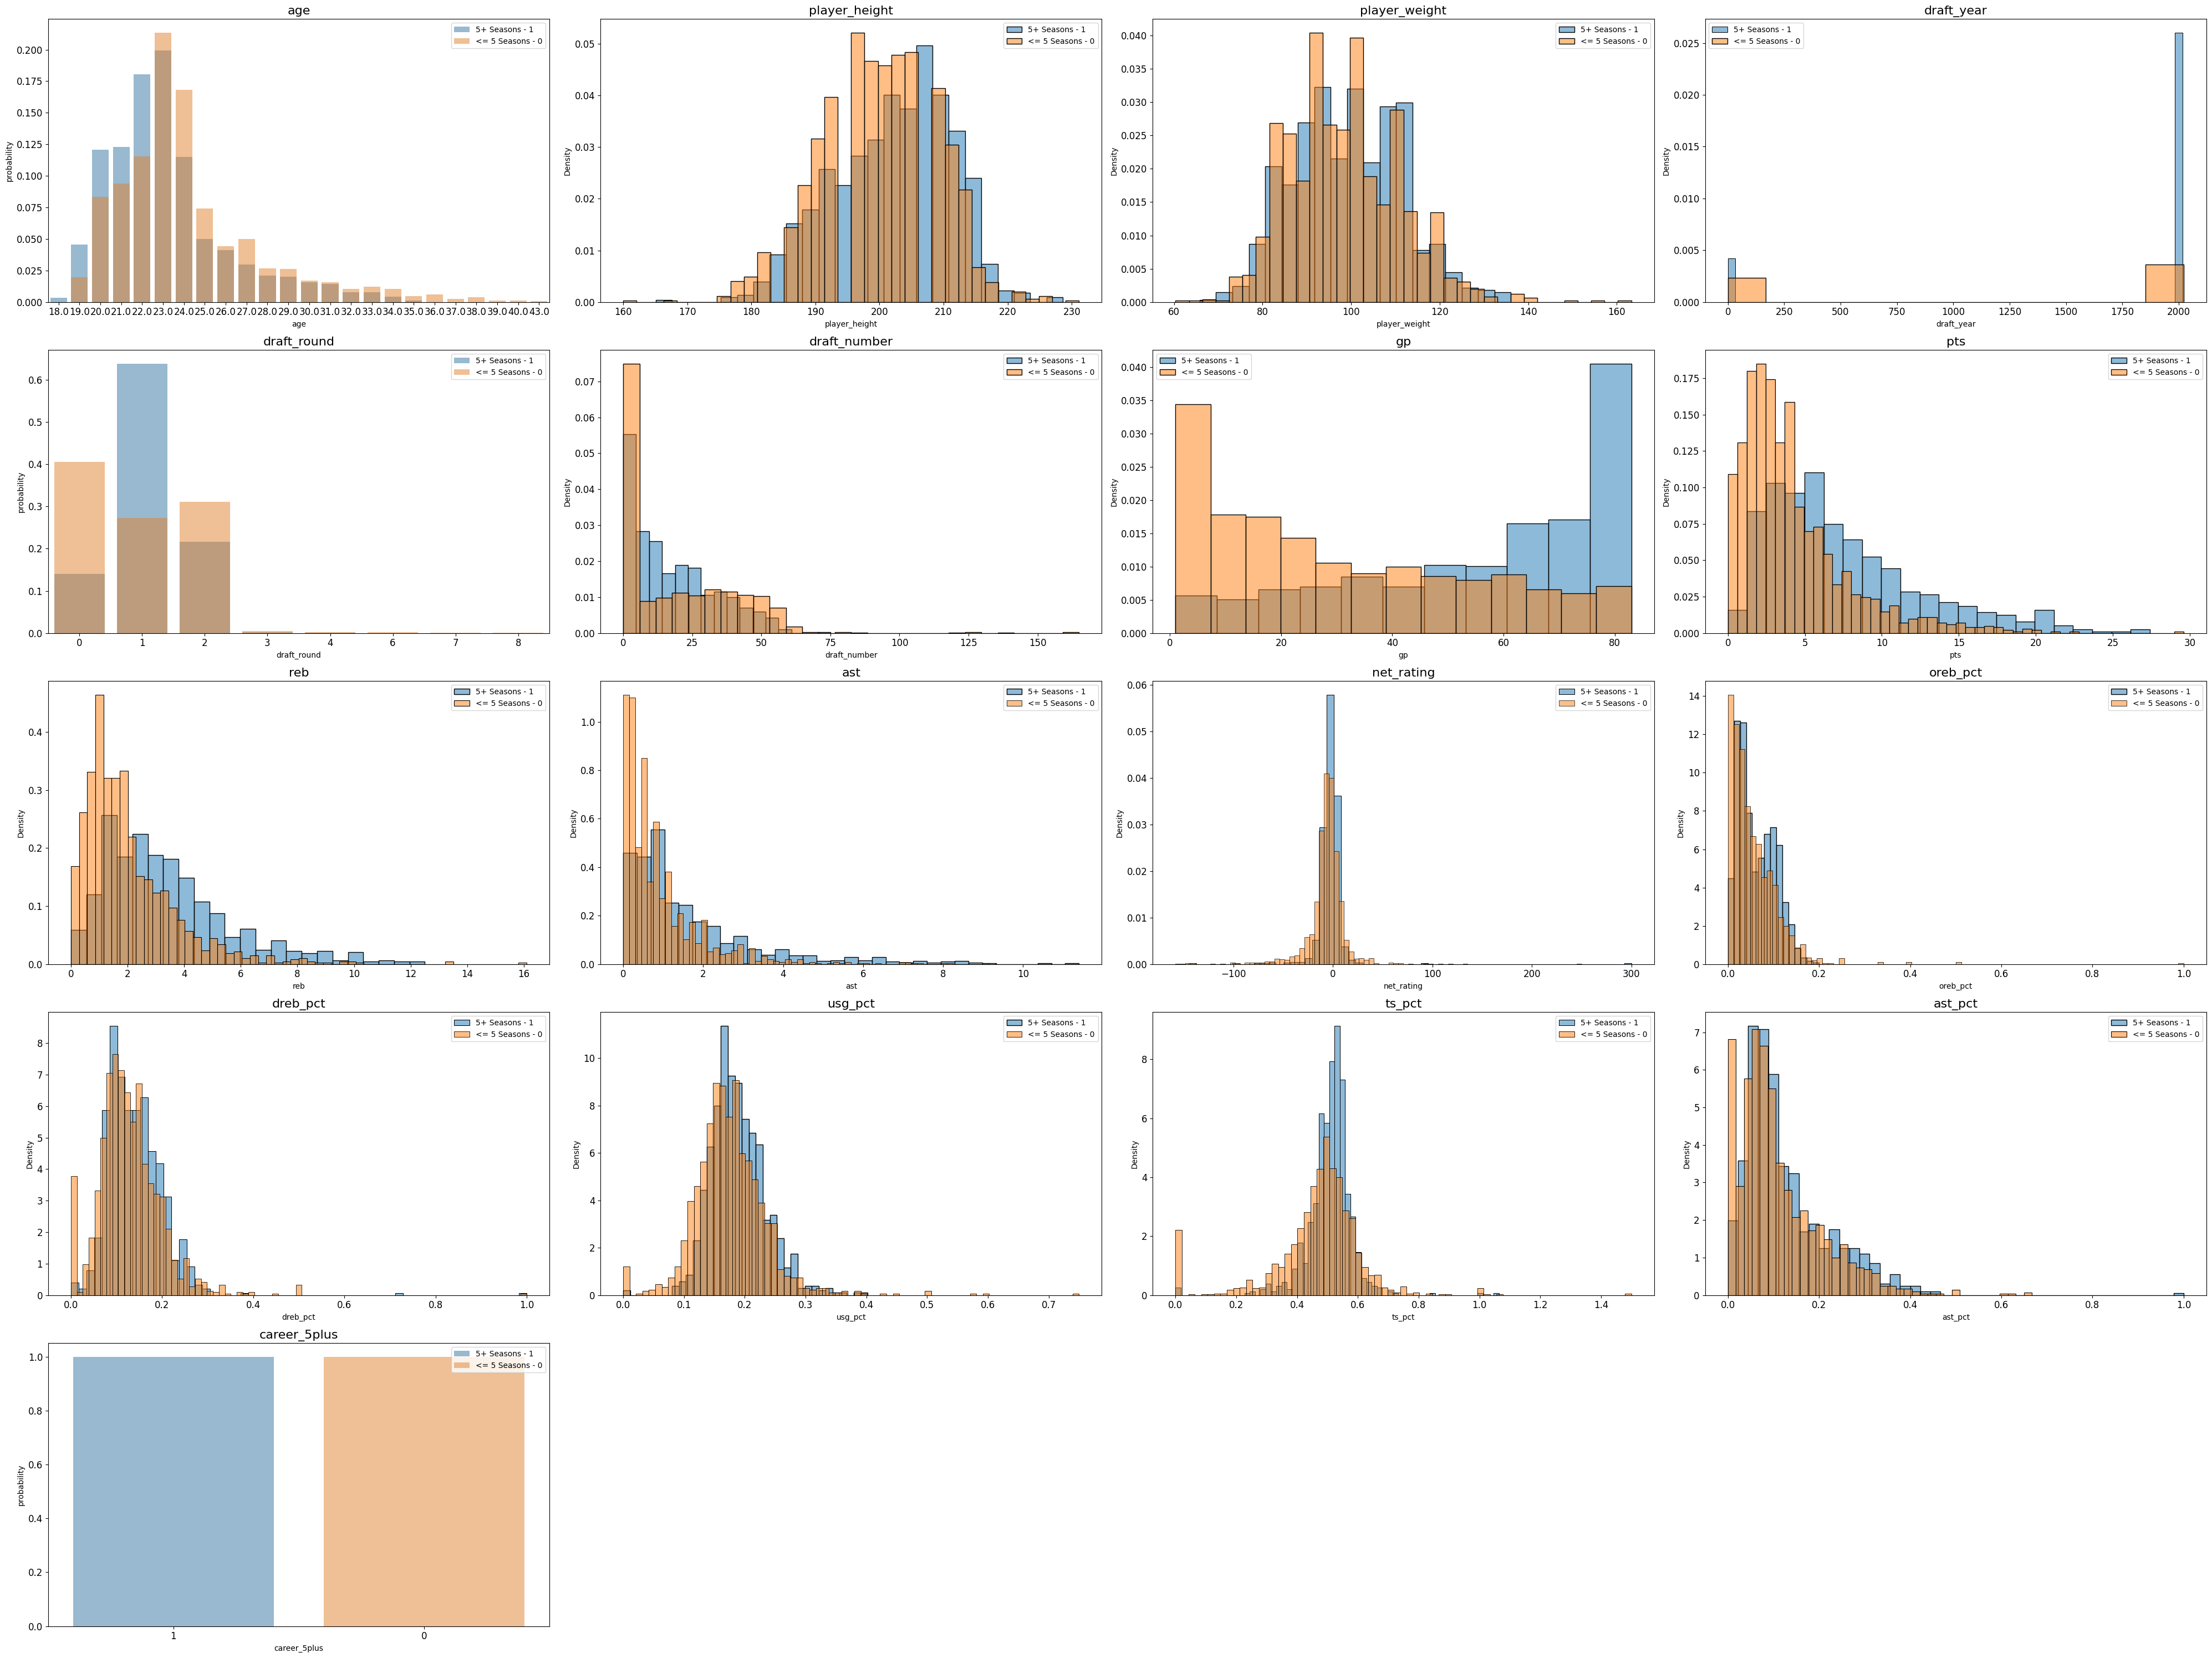

In [56]:
plt.figure(figsize=(10*n_columns, 6*n_rows))

cont = 0

for col in  df_player_1.columns:

    if col in df_player_1.select_dtypes(include='number'):

        cont += 1
        ax = plt.subplot(n_rows, n_columns, cont)

        if df_player_1[col].nunique() > 20:
            sns.histplot(data=df_player_1, x=col, bins='auto', stat='density', alpha=0.5)
            sns.histplot(data=df_player_0, x=col, bins='auto', stat='density', alpha=0.5)

        elif df_player_1[col].nunique() <= 20:
            sns.countplot(data=df_player_1, x=col, stat='probability', alpha=0.5)
            sns.countplot(data=df_player_0, x=col, stat='probability', alpha=0.5)

        ax.set_title(col, fontsize=16)
        ax.tick_params(axis='both', labelsize=12)
        ax.legend(['5+ Seasons - 1', '<= 5 Seasons - 0'])

plt.tight_layout()
plt.show()


### Al dividir nuestros datos por longevidad del jugador, podemos plantear nuestras primeras hipótesis.

**Edad**

Los jugadores que debutan a una edad más temprana presentan mayor probabilidad de superar las cinco temporadas en la NBA.

**Peso y Altura**

Las distribuciones normalizadas muestran un solapamiento casi completo entre clases.

**draft_round y draft_year**

Lo primero que llama la atención aquí es que los jugadores 'Undrafted' son muchos más en el grupo naranja, por tanto parece que si eras escogido de esta manera, tu probabilidad de durar más de 5 años se vería reducida. Lo mismo pasa en el sentido contrario con los escogidos durante el año y round 1, la mayoría de jugadores azules son seleccionados allí. Para los jugadores escogidos en el periodo 2, la diferencia no es tan grande. Por tanto ser seleccionado en el año/round 1 del draft se asocia fuertemente con una mayor probabilidad de una carrera prolongada en la NBA.

**draft_number**

Los jugadores escogidos entre los números 0 y 25, tienen mayor probabilidad de rendir más de 5 años dentro de la NBA

**gp**

Una mayor participación en la temporada inicial está asociada a una mayor probabilidad de longevidad profesional.

**pts, reb, ast**

Una mayor producción estadística en la temporada rookie incrementa la probabilidad de que un jugador tenga una carrera superior a cinco temporadas.

**usg_pct, ts_pct, net_rating**

usg_pct (porcentaje de uso ofensivo) y ts_pct (eficiencia de tiro) muestran un desplazamiento moderado pero consistente del azul

net_rating (impacto neto del jugador por 100 posesiones) presenta mayor dispersión, con solapamiento alto

La eficiencia ofensiva y el rol dentro del equipo en la temporada inicial podrían contribuir a la longevidad, aunque con menor poder discriminante que las variables de volumen.

**oreb_pct, dreb_pct, ast_pct**

No hay mucha discriminación en estas métricas porcentuales, las distribuciones son basicamente iguales.

    
    El análisis gráfico normalizado sugiere que la longevidad del jugador en la NBA está principalmente asociada al contexto del draft y al rendimiento temprano, mientras que las variables físicas y algunas métricas avanzadas presentan un menor poder discriminante. Estas observaciones motivan el uso de distintos algoritmos de clasificación para contrastar las hipótesis planteadas.

#### **Estudio de Correlaciones**

In [57]:
df_player_corr = df_player.copy()

In [58]:
columns_to_drop = columns_to_drop + ['career_5plus']
df_player_corr.drop(columns=columns_to_drop, inplace=True)

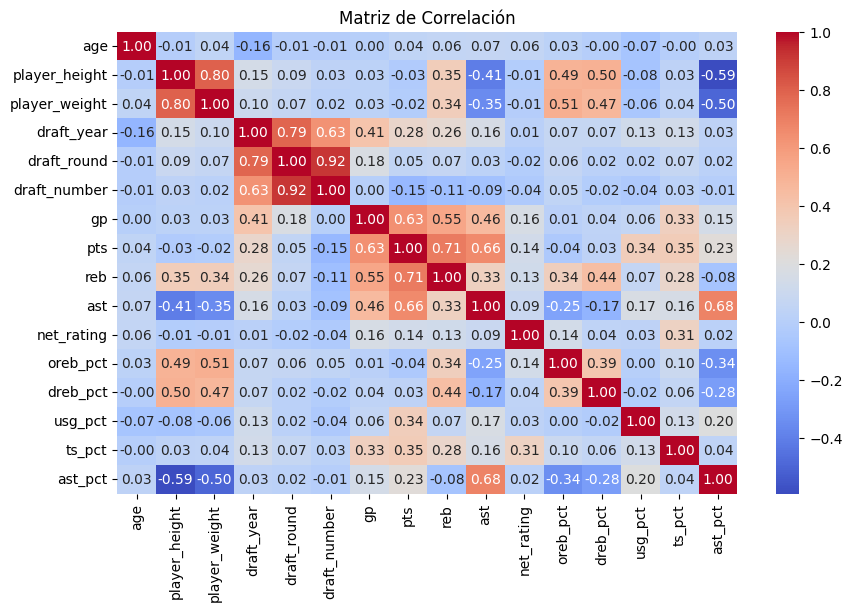

In [59]:
corr = df_player_corr.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

En base al umbral de:

|corr| < 0.3, débil y 0.3 <= |corr| < 0.7, moderada y |corr| > 0.7, alta

**Grupo 1 — Perfil físico**

- player_height - player_weight -> r ~ 0.80 (fuerte)

**Grupo 2 — Draft**

- draft_year - draft_round -> r ~ 1.00 (muy fuerte)
- draft_year - draft_number -> r ~ 0.92 (muy fuerte)
- draft_round - draft_number -> r ~ 0.92 (muy fuerte)

**Grupo 3 — Volumen de juego / producción**

- pts - reb -> r ~ 0.71 (fuerte)
- pts - ast -> r ~ 0.63 (moderada–fuerte)
- reb - gp -> r ~ 0.55 (moderada)
- ast - gp -> r ~ 0.46 (moderada)

**Grupo 4 — Métricas absolutas vs porcentuales**

- ast - ast_pct -> r ~ 0.68 (moderada–fuerte)
- reb - oreb_pct -> r ~ 0.34 (moderada)
- reb - dreb_pct -> r ~ 0.44 (moderada)

**Grupo 5 — Variables relativamente independientes**

- age -> sin correlaciones fuertes 
- net_rating -> correlaciones bajas con la mayoría 

Varios de los grupos presentan correlaciones altas entre sus variables, a nivel de modelo, esto es importante ya que no queremos introducir redundancia entre nuestras variables. Esto indica que no es adecuado utilizar todas las variables simultáneamente, por lo que se seleccionarán variables representativas de cad agrupo para evitar colinealidad y facilitar la interpretación.

#### **PCA**

In [75]:
columns_to_drop = columns_to_drop + ['player_weight','draft_year','draft_round']
df_player_pca = df_player.copy()
df_player_pca.drop(columns=columns_to_drop, inplace=True)

In [76]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_player_pca)

In [77]:
pca = PCA()
scores_pca = pca.fit_transform(X_scaled)

In [78]:
explained_var = pca.explained_variance_ratio_
explained_var 

array([0.24247401, 0.21187106, 0.08868394, 0.08289429, 0.07771703,
       0.07138191, 0.05844881, 0.04752843, 0.04322636, 0.02866532,
       0.02588149, 0.01445391, 0.00677342])

In [79]:
explained_var_cum = np.cumsum(explained_var)
explained_var_cum

array([0.24247401, 0.45434508, 0.54302901, 0.62592331, 0.70364034,
       0.77502225, 0.83347106, 0.88099949, 0.92422585, 0.95289117,
       0.97877267, 0.99322658, 1.        ])

Text(0.5, 1.0, 'Scree plot - Varianza explicada por componente')

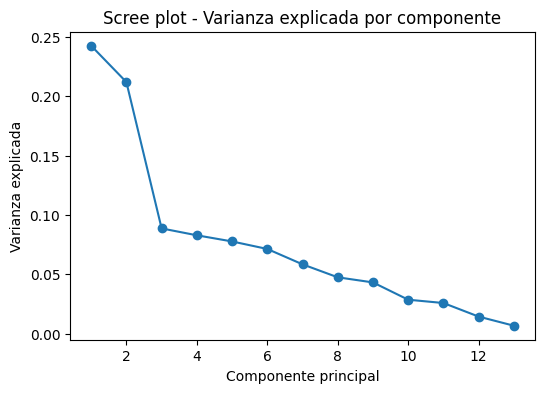

In [80]:
#scree plot - varianza explicada por componente
n_components = len(explained_var)

plt.figure(figsize=(6,4))
plt.plot(range(1, n_components + 1),
         explained_var,
         marker='o',
         linestyle='-')

plt.xlabel('Componente principal')
plt.ylabel('Varianza explicada')
plt.title('Scree plot - Varianza explicada por componente')


El análisis PCA muestra que los dos primeros componentes explican aproximadamente el 45% de la varianza total, con un punto de inflexión muy marcado tras el segundo componente. En base a los loadings podemos saber que tipo de información está relacionada a cada uno. Este análisis se realiza con fines exploratorios y no como entrada directa a los modelos de clasificación.

In [104]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=df_player_pca.columns
)

loadings.iloc[:,:2]

,PC1,PC2
age,0.036829,0.012349
player_height,-0.148100,0.488265
draft_number,-0.078428,-0.006075
gp,0.406819,0.153155
pts,0.500021,0.125985
reb,0.340837,0.399757
ast,0.470932,-0.179843
net_rating,0.142197,0.105767
oreb_pct,-0.074607,0.421363
dreb_pct,-0.030270,0.423493


Tenemos entonces:

**PC1 — Dimensión rendimiento / volumen**

pts - 0.500, ast - 0.471, gp - 0.407 ,reb - 0.341, ast_pct - 0.299 y ts_pct - 0.254

**PC2 — Dimensión perfil físico / rol interior**

Loadings más altos:

player_height - 0.488, oreb_pct - 0.421, dreb_pct - 0.423, reb - 0.400, ts_pct - 0.157 y gp - 0.153

En ambos componentes, nos quedaremos con las variables más representativas. pts en PC1 y player_height en PC2

### **ANOVA**

Revisaremos rapidamente algunos de los supuestos para hacer un análisis de varianza entre los dos grupos (career_5plus == 0 y career_5plus == 1). Para esto usaremos variables representativas, no todo el dataset. Estas muestran el comportamiento de la mayoría.

In [161]:
columnas = ['pts', 'draft_number', 'age']
clases = [0, 1]

resultados_shapiro = {}

for c in clases:
    
    resultados_shapiro[c] = {}
    
    for col in columnas:
        
        data = df_player.loc[df_player['career_5plus'] == c, col]
        
        stat, p = shapiro(data)

        resultados_shapiro[c][col] = {'stat': stat, 'p_value': p}

resultados_shapiro

{0: {'pts': {'stat': np.float64(0.8393797638132453),
   'p_value': np.float64(6.938237282082364e-38)},
  'draft_number': {'stat': np.float64(0.819563222419925),
   'p_value': np.float64(1.5059976203823545e-39)},
  'age': {'stat': np.float64(0.8678800243941627),
   'p_value': np.float64(3.550933952529191e-35)}},
 1: {'pts': {'stat': np.float64(0.9044665129256244),
   'p_value': np.float64(2.590147867578809e-23)},
  'draft_number': {'stat': np.float64(0.9158808741301087),
   'p_value': np.float64(5.6471658148496e-22)},
  'age': {'stat': np.float64(0.8924555931003649),
   'p_value': np.float64(1.347432643429842e-24)}}}

Aunque algunas variables no cumplen estrictamente los supuestos de normalidad, el ANOVA se utiliza con fines exploratorios para evaluar la capacidad discriminante de las variables, siendo robusto a estas desviaciones en contextos como el presente. Usamos las candidatas finales:

Dado que las variables pts, reb y ast presentan altas correlaciones entre sí y cargan de forma dominante en el primer componente principal, se decide conservar únicamente pts como variable representativa de dicha dimensión, con el objetivo de reducir la colinealidad del modelo sin pérdida sustancial de información.

In [150]:
columns_to_drop = columns_to_drop + ['ast','reb']
df_player_anova = df_player.copy()
df_player_anova.drop(columns=columns_to_drop, inplace=True)

In [158]:
from scipy.stats import f_oneway

resultados_anova = {}

for col in df_player_anova.columns:
    
    grupo_0 = df_player_anova.loc[df_player_anova['career_5plus'] == 0, col]
    grupo_1 = df_player_anova.loc[df_player_anova['career_5plus'] == 1, col]
    
    stat, p = f_oneway(grupo_0, grupo_1)
    
    resultados_anova[col] = {'F': stat, 'p_value': p}

df_anova = pd.DataFrame(resultados_anova).T
df_anova.sort_values(by='F', ascending=False)

,F,p_value
career_5plus,inf,0.000000e+00
gp,717.760925,1.595765e-139
pts,377.734927,1.428544e-78
ts_pct,63.552270,2.334148e-15
age,55.244339,1.445018e-13
usg_pct,37.414813,1.101933e-09
net_rating,21.399482,3.915087e-06
ast_pct,21.284804,4.154358e-06
dreb_pct,18.516615,1.747811e-05
oreb_pct,14.812565,1.216589e-04


Las variables que mpas separan ambos grupos son gp y pts por diferencia, ambas variables con f-values altos y p-value < 0.05, seguidos de ts_pct y age.

Más en detalle ANOVA muestra que las variables relacionadas con la participación y el rendimiento ofensivo del jugador, como gp y pts, presentan las mayores diferencias entre jugadores con carreras largas y cortas. Asimismo, variables asociadas a la eficiencia y al rol ofensivo, como ts_pct y usg_pct, resultan estadísticamente significativas. Variables como net_rating, ast_pct, oreb_pct y dreb_pct muestran un poder discriminante moderado. 

Por el contrario, las variables físicas como player_height presentan un menor poder explicativo. Aunque variables como draft_number no muestran diferencias significativas en términos de medias, se mantienen en el análisis posterior debido a su relevancia conceptual y a su posible efecto no lineal en los modelos de clasificación.

variables seleccionadas para modelos: 

    gp, pts, ts_pct, usg_pct, age, net_rating, player_height, draft_number

## **3. Clasificación**

### **3.1 Modelo de Regresión Logística**

In [163]:
X = df_player[[
    'gp', 'pts', 'ts_pct',
    'usg_pct', 'age', 'net_rating',
    'player_height', 'draft_number'
]]

y = df_player['career_5plus']

Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.80       330
           1       0.63      0.52      0.57       181

    accuracy                           0.72       511
   macro avg       0.70      0.68      0.68       511
weighted avg       0.72      0.72      0.72       511



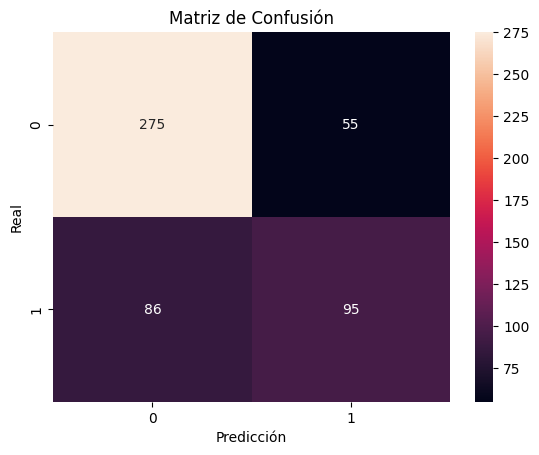

In [219]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42,
    stratify = y #para mantener la proporción de clases en train y test
)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_rep)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


El modelo de regresión presenta un rendimiento normal, alcanzando un accuracy del 72% en el conjunto de test. La confusion matrix muestra que el modelo clasifica correctamente la mayoría de los jugadors con carreras cortas, mientras que muestra una capacidad regular para identifciar jugadores con carreras de más de 5 temporadas.

TN = 275 -> jugadores con carrera <= 5 temporadas correctamente clasificados.

FP = 55 -> jugadores con carrera <= 5 temporadas clasificados erroneamente como >5

FN = 86 -> jugadores con carrera > 5 temporadas clasificados erróneamente como ≤ 5

TP = 95 -> jugadores con carrera > 5 temporadas correctamente clasificados.

Para career_plus == 0, precision = 0.76, recall = 0.83

Cuando el modelo predice 0, acierta 76% de las vecesm y detecta correctamente el 83% de las carreras cortas.

Para career_plus == 1, precision = 0.63, recall = 0.52

Cuando el modelo predice 1, solo acierta el 63% y detecta el 52% de los jugadores que realmente duran >= 5 temporadas.

In [184]:
y_prob = model.predict_proba(X_test_scaled)[:, 1]
prob_0 = y_prob[y_test == 0]
prob_1 = y_prob[y_test == 1]

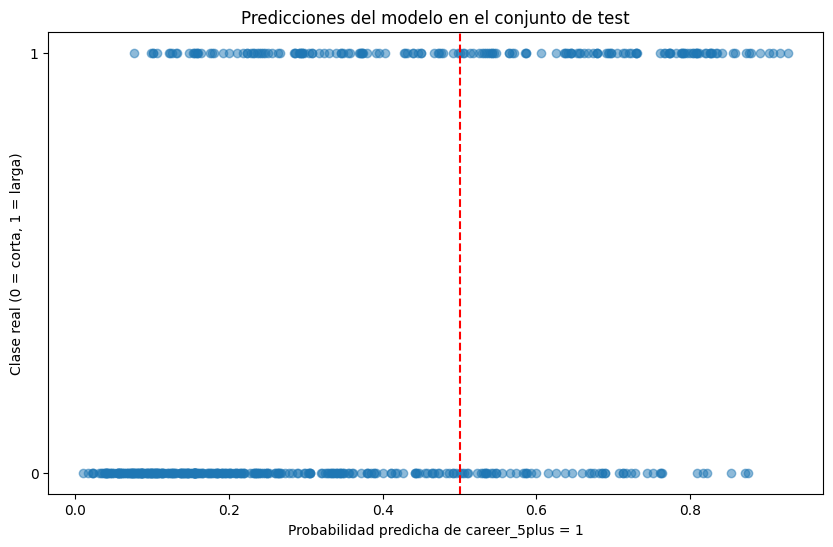

In [190]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(
    y_prob,
    y_test,
    alpha=0.5
)

plt.axvline(0.5, color='red', linestyle='--')

plt.xlabel('Probabilidad predicha de career_5plus = 1')
plt.ylabel('Clase real (0 = corta, 1 = larga)')
plt.title('Predicciones del modelo en el conjunto de test')

plt.yticks([0, 1])

plt.show()


### **3.2 KNN**

In [213]:
k_values = [3, 7, 11]

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    print(f'\nK = {k}')
    print(classification_report(y_test, y_pred))


K = 3
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       330
           1       0.60      0.54      0.57       181

    accuracy                           0.71       511
   macro avg       0.68      0.67      0.67       511
weighted avg       0.70      0.71      0.71       511


K = 7
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       330
           1       0.65      0.55      0.60       181

    accuracy                           0.74       511
   macro avg       0.71      0.70      0.70       511
weighted avg       0.73      0.74      0.73       511


K = 11
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       330
           1       0.68      0.59      0.63       181

    accuracy                           0.76       511
   macro avg       0.73      0.72      0.72       511
weighted avg       0.75      0.76      0.75       51

Por medio de GridSearch averiguaremos dentro de este rango, cuál es el modelo óptimo.

#### Parametrización y entrenamiento de Grid Search

In [198]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 11,
 'p': 2,
 'weights': 'uniform'}

In [207]:
model_params={
    'n_neighbors':[3, 5, 7, 9, 11, 15]
}

model = KNeighborsClassifier()
gscv = GridSearchCV(model, model_params)
model_gs = gscv.fit(X_train_scaled, y_train)

print(f'Best: {model_gs.best_score_,model_gs.best_params_}')

Best: (np.float64(0.7666666666666666), {'n_neighbors': 9})


Construimos entonces nuestro modelo con k = 9

Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       330
           1       0.66      0.59      0.62       181

    accuracy                           0.75       511
   macro avg       0.72      0.71      0.72       511
weighted avg       0.74      0.75      0.74       511



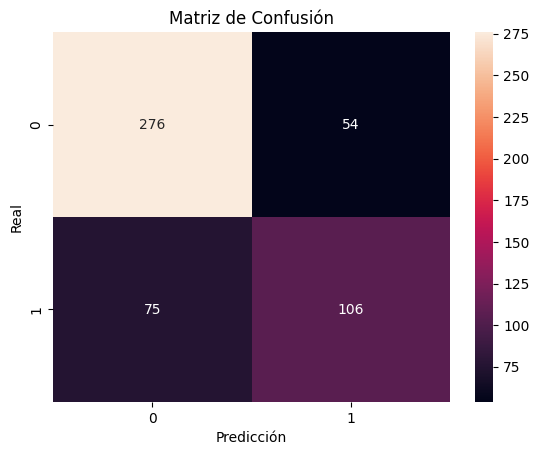

In [218]:
best_knn = model_gs.best_estimator_
y_pred = best_knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_rep)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

El modelo de KNN optimizado meidante GridSearch presenta un mejor rendimiento que la regresión logística, con un accuracy de 75% y mejorando significativamente la detección de jugadores con carreras > 5. Para career_5plus == 1, precision = 0.66, recall = 0.59 y para career_5plus == 0 0.79 y 0.84 respectivamente.

TN = 275 -> jugadores con carrera <= 5 temporadas correctamente clasificados.

FP = 54 -> jugadores con carrera <= 5 temporadas clasificados erroneamente como >5

FN = 75 -> jugadores con carrera > 5 temporadas clasificados erróneamente como ≤ 5

TP = 106 -> jugadores con carrera > 5 temporadas correctamente clasificados.

Hay una reducción de falsos negativos por tanto el modelo mejoró en calcular jugadores longevos.

### **3.3 Árboles de decisión**

In [235]:
tree = DecisionTreeClassifier(
    random_state=42
)

tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_rep)
print(conf_matrix)

Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.80       330
           1       0.63      0.52      0.57       181

    accuracy                           0.72       511
   macro avg       0.70      0.68      0.68       511
weighted avg       0.72      0.72      0.72       511

[[275  55]
 [ 86  95]]


In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [5, 10, 20]
}

grid_tree = GridSearchCV(
    estimator=tree,           #Modelo base que se va a optimizar
    param_grid=param_grid,    #Conjunto de hiperparámetros a probar
    scoring='f1',             #Métrica a optimizar (adecuada por desbalance)
    cv=5                      #Número de particiones en validación cruzada / revisar
)

grid_tree.fit(X_train, y_train)

print("Best params:", grid_tree.best_params_)
print("Best f1 score:", grid_tree.best_score_)


Best params: {'max_depth': 5, 'min_samples_leaf': 5}
Best f1 score: 0.6041504301649755


Para la regularización del árbol de decisión se definió un grid de hiperparámetros centrado en distintos niveles razonables de complejidad del modelo. Explorando un rango de valores razonable que cubre desde árboles simples hasta estructuras más complejas sin introducir una búsqueda excesivamente amplia.

0.7495107632093934
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       330
           1       0.66      0.61      0.63       181

    accuracy                           0.75       511
   macro avg       0.73      0.72      0.72       511
weighted avg       0.75      0.75      0.75       511



Text(0.5, 1.0, 'Matriz de Confusión')

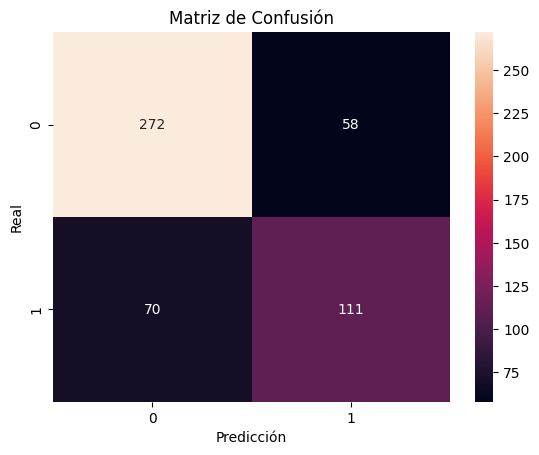

In [239]:
best_tree = grid_tree.best_estimator_

y_pred_tree = best_tree.predict(X_test)

print(accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt='d')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')

El arbol de decisión optimizado mediante GridSearch alcanzó un accuracy del ~75% en el conjunto test y un recall de 61% para la clase positiva, mostrando una mejora clara frente a la regresión logística y un rendimiento comparable al KNN optimizado.

[Text(0.5350877192982456, 0.9166666666666666, 'gp <= 59.5\ngini = 0.457\nsamples = 2040\nvalue = [1318, 722]\nclass = 0'),
 Text(0.2807017543859649, 0.75, 'gp <= 28.5\ngini = 0.339\nsamples = 1411\nvalue = [1106, 305]\nclass = 0'),
 Text(0.40789473684210525, 0.8333333333333333, 'True  '),
 Text(0.14035087719298245, 0.5833333333333334, 'usg_pct <= 0.156\ngini = 0.233\nsamples = 846\nvalue = [732, 114]\nclass = 0'),
 Text(0.07017543859649122, 0.4166666666666667, 'draft_number <= 10.5\ngini = 0.133\nsamples = 308\nvalue = [286, 22]\nclass = 0'),
 Text(0.03508771929824561, 0.25, 'net_rating <= -5.05\ngini = 0.07\nsamples = 193\nvalue = [186.0, 7.0]\nclass = 0'),
 Text(0.017543859649122806, 0.08333333333333333, 'gini = 0.018\nsamples = 109\nvalue = [108, 1]\nclass = 0'),
 Text(0.05263157894736842, 0.08333333333333333, 'gini = 0.133\nsamples = 84\nvalue = [78, 6]\nclass = 0'),
 Text(0.10526315789473684, 0.25, 'draft_number <= 34.5\ngini = 0.227\nsamples = 115\nvalue = [100, 15]\nclass = 0'),

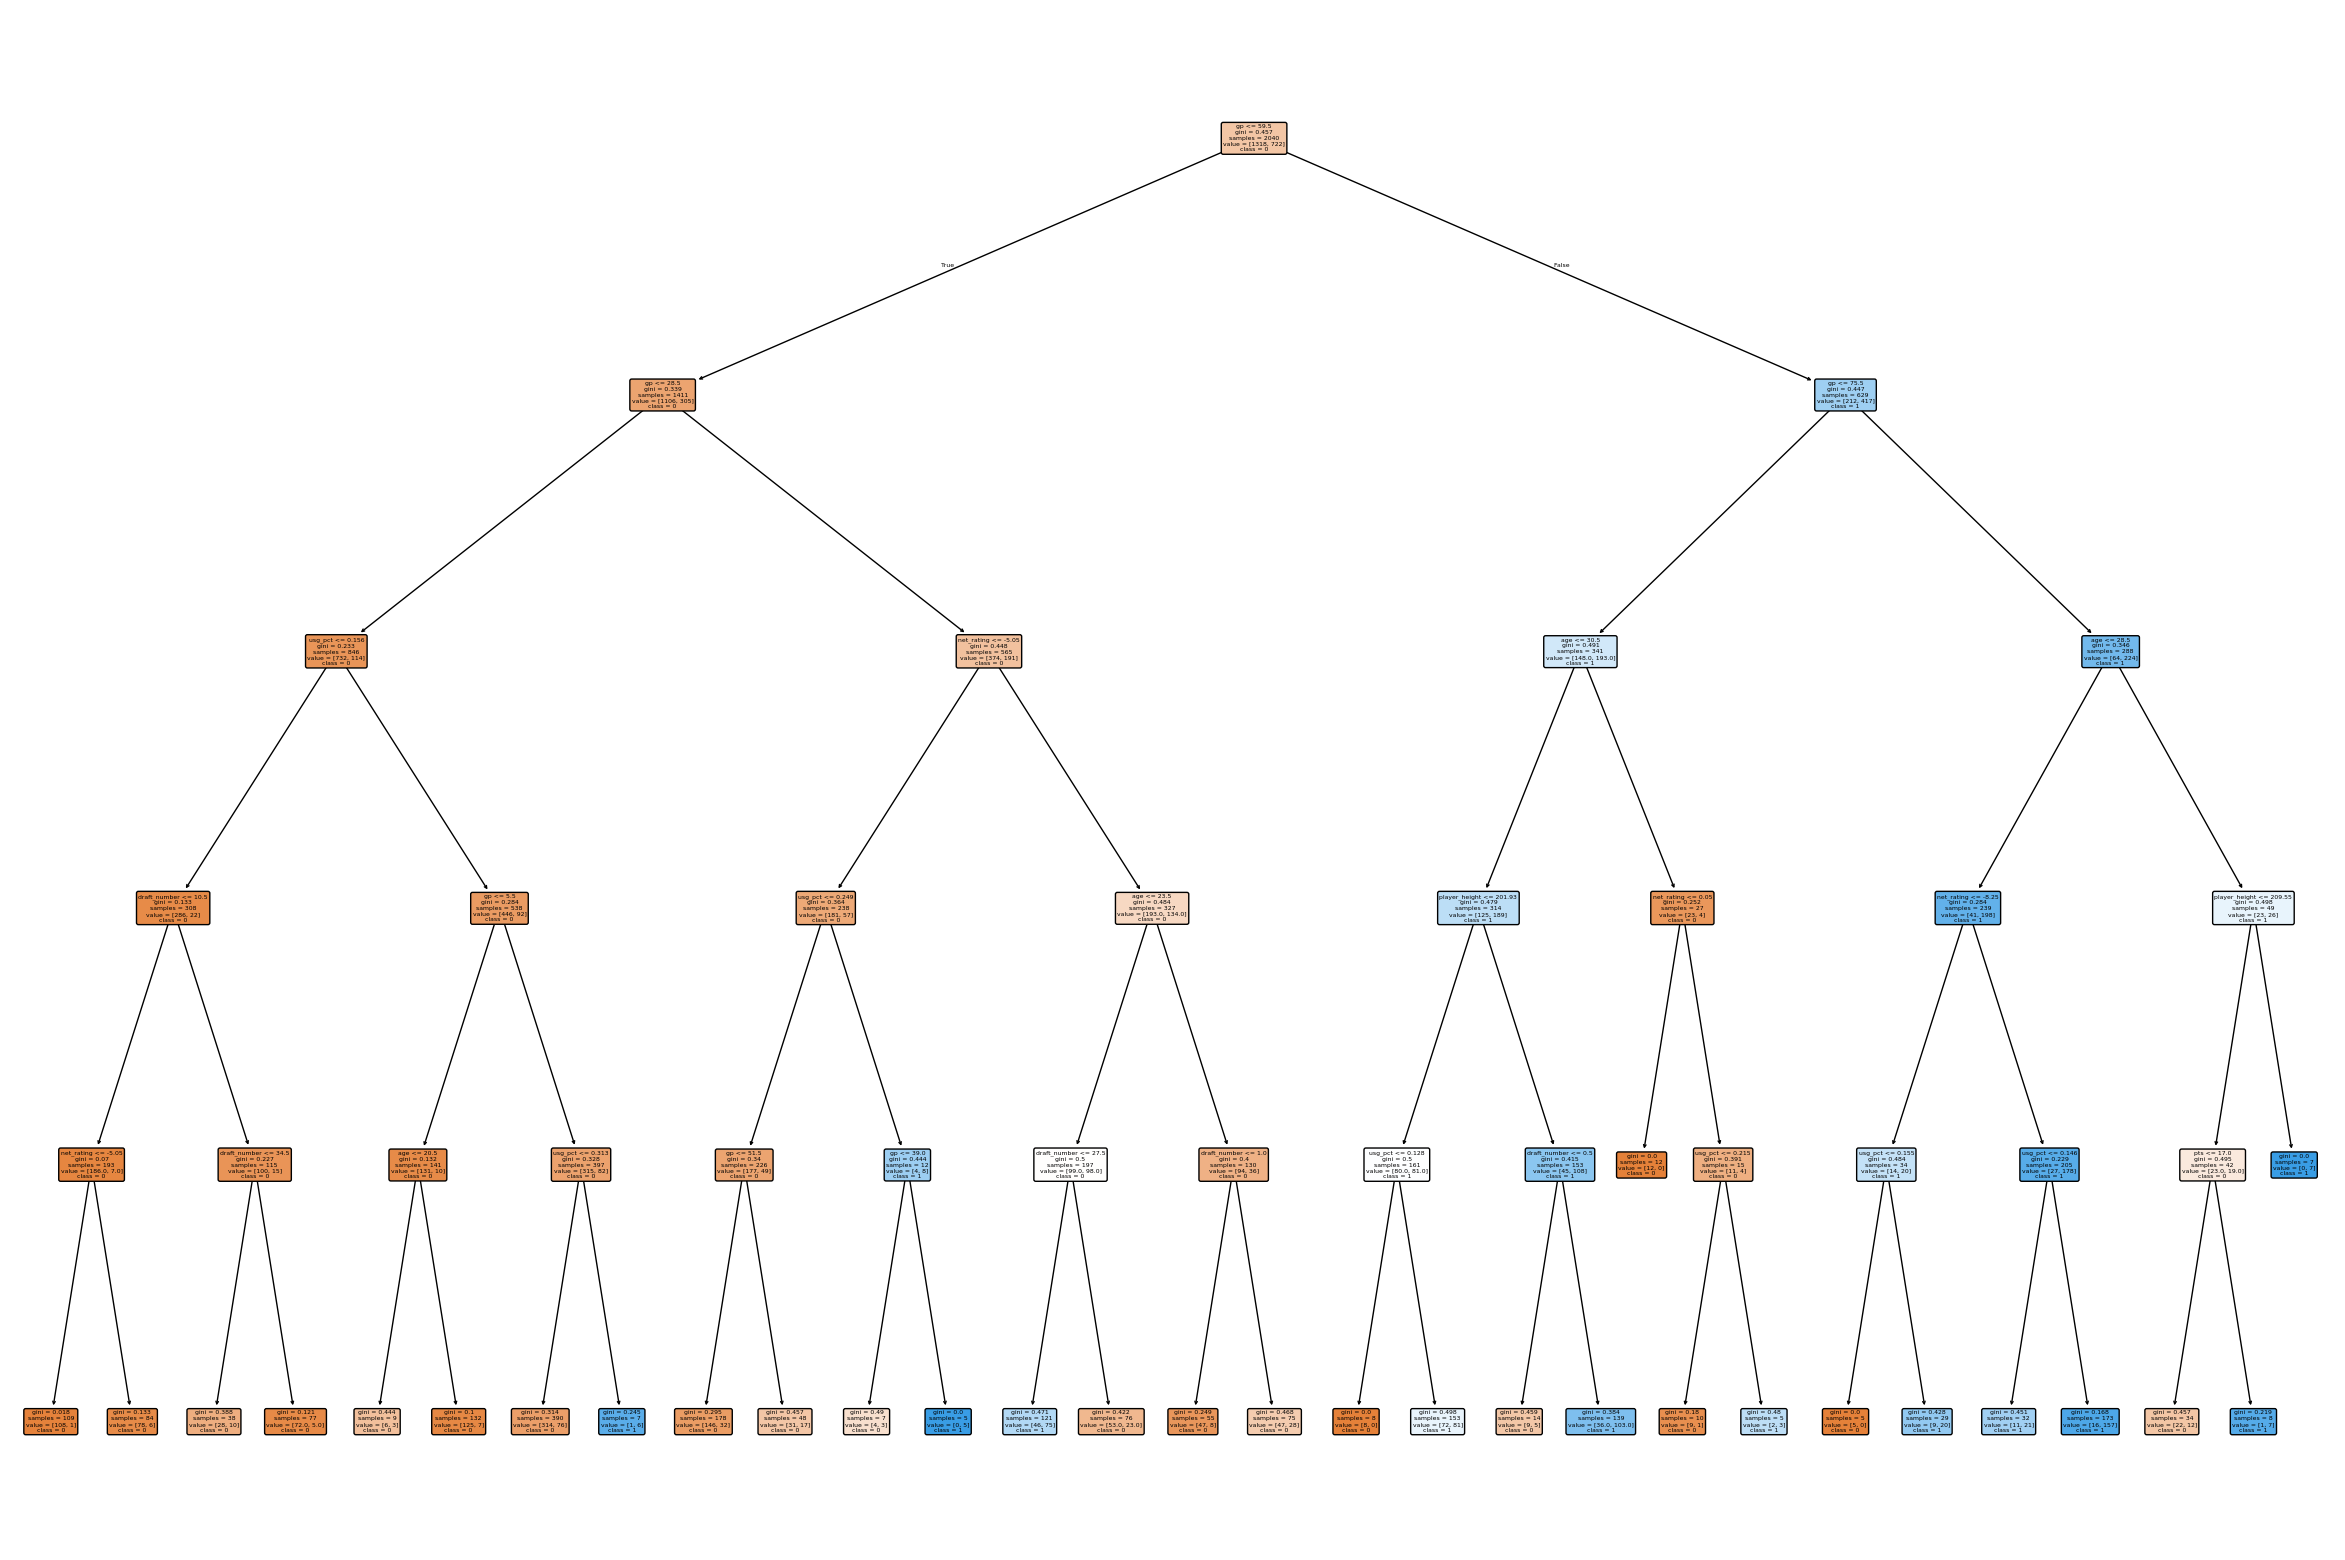

In [ ]:
plt.figure(figsize=(30, 20))
tree.plot_tree(best_tree)

### **3.4 Support Vector Machine (SVM)**

Entiendo que lo que hace SVM es intentar dibujar una línea o curva que separe ambos grupos (0 y 1), sin embargo antes ya vimos quue el problema no puede determinarse por la división de una línea como vimos en la regresión y funciona mejor cuando se trata de soluciones no lineales como KNN y Árboles. Utilizaremos entonces el método de SVM 'rbf' que puede dibujar curvas, rodear grupos de puntos y se adapta a formas extrañas o complejas.

In [ ]:
svm = SVC(probability=False, random_state=42)  

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],          #Cuánto castigo damos a equivocarnosa
    'gamma': ['scale', 0.1]    #hasta dónde llega la influencia de un punto
}

grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='f1',           
    cv=5
)

grid_svm.fit(X_train_scaled, y_train)

print("Best params:", grid_svm.best_params_)
print("Best CV F1-score:", grid_svm.best_score_)


Best params: {'C': 1, 'gamma': 'scale'}
Best CV F1-score: 0.6303908049934703


Exploramos niveles razonables de regularización y complejidad de la frontera, permitiendo evaluar modelos desde configuraciones conservadoras hasta otras más flexibles sin introducir una búsqueda excesivamente amplia.

0.7455968688845401
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       330
           1       0.69      0.52      0.59       181

    accuracy                           0.75       511
   macro avg       0.73      0.69      0.70       511
weighted avg       0.74      0.75      0.74       511



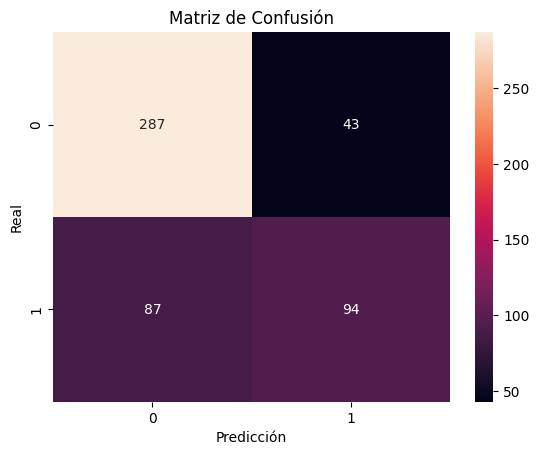

In [249]:
best_svm = grid_svm.best_estimator_

y_pred_svm = best_svm.predict(X_test_scaled)

print(accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

SVM con el kernel 'rbf' no mejora la detección de carreras largas respecto al árbol regularizado. Su reccal para la clase 1 es similar a la regresión logística y peor que KNN Y Árboles. TN = 287 (muy bien clase 0), FP = 43 (pocos falsos positivos), FN = 87 (muchos falsos negativos) y TP = 94 (pocos verdaderos positivos). Pareciese que este algoritmo priorizara la precisión en la clase mayoritaria.

## **4. Conclusiones**

En este trabajo se analizó la longevidad de los jugadores de la NBA, definida como la permanencia en la liga durante más de cinco temporadas, mediante distintos algoritmos de clasificación. Antes de modelar, el análisis exploratorio del dataset permitió identificar que las mayores diferencias entre jugadores con carreras largas y cortas se concentran en variables relacionadas con la participación en el juego, el rendimiento ofensivo y la eficiencia, mientras que las variables físicas presentan un menor poder discriminante. El análisis de correlaciones mostró relaciones fuertes entre métricas ofensivas, lo que confirmó la existencia de redundancia entre variables y justificó el uso de técnicas como PCA para comprender la estructura subyacente de los datos. Asimismo, el análisis ANOVA evidenció diferencias estadísticamente significativas entre ambas clases en variables clave como partidos jugados, puntos, eficiencia de tiro y uso ofensivo, anticipando que la separación entre clases no sería trivial ni lineal.

La regresión logística se utilizó como modelo base y alcanzó una accuracy del 72%. La matriz de confusión mostró que, aunque el modelo clasifica correctamente a la mayoría de jugadores con carrreras cortas (275 verdaderos negativos), presenta una elevada cantidad de falsos negativos (86), es decir, jugadores con carreras largas clasificados erróneamente como carreras cortas. Este resultado indica que la regresión logística tiene dificultades para identificar correctamente a los jugadores longevos, lo que sugiere que la longevidad no puede explicarse adecuadamente mediante una combinación lineal simple de las variables disponibles.

El modelo KNN, tras su optimización, mejoró el rendimiento global alcanzando una accuracy cercana al 75%. Su matriz de confusión muestra un aumento en el número de verdaderos positivos (106 frente a 95 en la regresión logística) y una reducción de los falsos negativos. Este comportamiento indica que el modelo es más eficaz identificando jugadores con carreras largas, lo que sugiere la existencia de perfiles similares de jugadores longevos en el espacio de variables. Sin embargo, aunque mejora la detección de la clase positiva, KNN no ofrece reglas explícitas que permitan interpretar fácilmente las decisiones del modelo.

El árbol de decisión regularizado presenta resultados muy similares en términos de accuracy (aproximadamente 75%), pero destaca por ofrecer el mejor equilibrio entre clases. Su matriz de confusión muestra el mayor número de verdaderos positivos (111) y el menor número de falsos negativos (70) entre todos los modelos evaluados. Esto indica que el árbol es el modelo que mejor identifca a los jugadores con carreras largas, sin penalizar en exceso la clasificación de carreras cortas. Desde un punto de vista interpretativo, el árbol permite describir la longevidad mediante reglas que combinan variables de participación, eficiencia y rol ofensivo, lo que refuerza la idea de que la duración de la carrera profesional surge de la interacción entre múltiples factores.

El modelo SVM con kernel 'rbf' alcanzó una accuracy similar a la de KNN y el árbol de decisión, en torno al 75%. No obstante, su matriz de confusión revela un comportamiento más conservador, con un número elevado de falsos negativos (87) y un número reducido de falsos positivos. Esto implica que el SVM tiende a clasificar a los jugadores como carreras cortas cuando existe incertidumbre, lo que limita su capacidad para detectar jugadores longevos. Aunque el SVM confirma la naturaleza no lineal del problema, su rendimiento para la clase positiva y su baja interpretabilidad reducen su utilidad práctica frente a otros modelos.

Los resultados muestran que todos los modelos alcanzan accuracies similares, por lo que la selección del modelo no puede basarse únicamente en esta métrica. El análisis de las matrices de confusión revela que la principal diferencia entre modelos reside en su capacidad para identificar correctamente a los jugadores con carreras largas. En este sentido, el árbol de decisión regularizado destaca como el mejor modelo, al minimizar los falsos negativos y ofrecer una interpretación clara de las decisiones. Por ello, se selecciona como modelo final, ya que combina un rendimiento predictivo sólido con la capacidad de extraer conocimiento relevante sobre los factores que influyen en la longevidad de los jugadores en la NBA.


## **5. Insight final según todo el análisis**

    El análisis muestra que la longevidad de los jugadores en la NBA está principalmente determinada por su capacidad de mantener una participación constante y aportar valor de forma eficiente dentro de un rol claro, más que por características físicas o expectativas iniciales como el puesto de draft. Los jugadores con carreras largas tienden a combinar presencia sostenida en pista con eficiencia ofensiva y contribución positiva al rendimiento colectivo, lo que evidencia que la permanencia en la liga depende de la adaptación y del impacto real en el juego a lo largo del tiempo